In [1]:
#Import necessary libraries
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Preprocessing


## Load and View dataset

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ecg-heartbeat-covid-19/beat_dataset_250Hz_augmented_balanced_v1_lead_ii.csv
/kaggle/input/ecg-heartbeat-covid-19/heartbeat_125_lead_ii_train_validation_dataset.csv
/kaggle/input/ecg-heartbeat-covid-19/heartbeat_250_lead_ii_validation_dataset.csv
/kaggle/input/ecg-heartbeat-covid-19/heartbeat_125_lead_ii_test_dataset.csv


In [4]:
#Load datasets
train_data = pd.read_csv('/kaggle/input/ecg-heartbeat-covid-19/heartbeat_125_lead_ii_train_validation_dataset.csv', header=None)
test_data = pd.read_csv('/kaggle/input/ecg-heartbeat-covid-19/heartbeat_125_lead_ii_test_dataset.csv', header=None)


In [5]:
display(train_data.head(10))

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,-0.060135,-0.071180,-0.061759,-0.049604,-0.040344,-0.023758,-0.012891,0.005379,0.015817,0.032224,...,0.180003,0.152982,0.142823,0.115006,0.103879,0.075164,0.063942,0.034352,0.023224,3.0
1,-0.149637,-0.209404,-0.189339,-0.198036,-0.188358,-0.190045,-0.181607,-0.179280,-0.169933,-0.163575,...,0.021628,0.003119,-0.008381,-0.023519,-0.026417,-0.035812,-0.030353,-0.025364,0.016363,3.0
2,-0.078766,-0.143803,-0.108988,-0.121539,-0.097006,-0.097683,-0.074337,-0.068817,-0.045906,-0.037442,...,-0.246215,-0.257335,-0.253452,-0.266619,-0.257747,-0.273697,-0.251800,-0.280158,-0.179819,2.0
3,-0.111657,-0.097021,-0.034344,-0.055310,-0.096227,-0.132168,-0.132719,-0.132984,-0.121765,-0.095215,...,0.001680,-0.001836,0.002038,-0.002309,0.002688,-0.003249,0.004160,-0.005873,0.010133,3.0
4,-0.121302,-0.152412,-0.107419,-0.089462,-0.086153,-0.096702,-0.078167,-0.061817,-0.029461,0.001103,...,0.233199,0.223637,0.219917,0.208895,0.204643,0.196210,0.158563,0.015434,0.009521,2.0
5,-0.011291,0.109466,0.047669,0.100464,0.067053,0.103634,0.080569,0.109367,0.091647,0.115625,...,0.291468,0.372770,0.422070,0.517631,0.564590,0.680566,0.709585,0.887779,0.686538,0.0
6,-0.063255,-0.105325,-0.076707,-0.083637,-0.073897,-0.072257,-0.051759,-0.037096,-0.008888,0.012462,...,-0.071231,-0.088162,-0.097686,-0.113433,-0.114250,-0.122252,-0.109074,-0.116012,-0.067008,3.0
7,-0.069506,-0.117436,-0.128329,-0.166840,-0.190288,-0.211523,-0.218821,-0.230189,-0.232954,-0.232475,...,-0.052773,-0.049801,-0.041569,-0.044122,-0.039094,-0.045002,-0.037304,-0.048653,-0.004208,0.0
8,-0.005406,-0.018760,0.004450,0.027952,0.060203,0.081049,0.099514,0.109872,0.122935,0.134522,...,0.052009,0.046677,0.043085,0.028691,0.013538,-0.016805,-0.040689,-0.075225,-0.042976,4.0
9,-0.063327,-0.087450,-0.074321,-0.075503,-0.067682,-0.065432,-0.056227,-0.049605,-0.038839,-0.031456,...,0.000880,-0.000970,0.001086,-0.001243,0.001462,-0.001788,0.002322,-0.003339,0.005938,0.0


In [6]:
test_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
0,-0.040028,-0.021535,-0.025052,-0.022122,-0.026819,-0.029762,-0.035958,-0.038550,-0.041734,-0.043648,...,-0.019417,-0.030164,-0.054315,-0.078677,-0.094118,-0.093426,-0.092131,-0.085514,-0.087509,1
1,-0.126536,-0.141069,-0.139401,-0.142002,-0.140808,-0.142198,-0.141548,-0.142507,-0.141241,-0.138303,...,0.025766,-0.001506,-0.021816,-0.038134,-0.050032,-0.064095,-0.074923,-0.087024,-0.091415,0
2,-0.224828,-0.333595,-0.321375,-0.345750,-0.333376,-0.335853,-0.320068,-0.316699,-0.303130,-0.300261,...,0.003161,-0.003456,0.003842,-0.004361,0.005092,-0.006182,0.007971,-0.011392,0.020179,2
3,-0.140078,-0.178614,-0.137127,-0.121557,-0.087410,-0.066549,-0.038563,-0.019643,0.005361,0.023789,...,0.002090,-0.002288,0.002541,-0.002876,0.003341,-0.004028,0.005145,-0.007259,0.012608,3
4,-0.019169,-0.019539,-0.009231,-0.006223,0.001459,0.011653,0.026683,0.042684,0.062260,0.084425,...,0.128184,0.111893,0.095477,0.077568,0.064593,0.052727,0.044410,0.030482,0.019070,3
5,-0.082441,-0.069675,-0.074895,-0.073214,-0.074935,-0.072719,-0.072734,-0.071361,-0.072028,-0.072062,...,0.015487,-0.021932,-0.051836,-0.070707,-0.087088,-0.097379,-0.108542,-0.111069,-0.118313,0
6,-0.045494,-0.045202,-0.032287,-0.032409,-0.036711,-0.048412,-0.058119,-0.065745,-0.067573,-0.066448,...,-0.018252,-0.019898,-0.017915,-0.022593,-0.030018,-0.040475,-0.042991,-0.042493,-0.028169,0
7,-0.039380,-0.045392,-0.047813,-0.046269,-0.042379,-0.040524,-0.043932,-0.051464,-0.057489,-0.057994,...,0.046794,0.038532,0.028047,0.015245,0.002376,-0.008603,-0.016933,-0.024299,-0.031229,4
8,-0.112031,-0.089016,-0.095627,-0.088904,-0.085675,-0.076382,-0.074524,-0.077996,-0.090499,-0.101643,...,0.080162,0.057521,0.035505,0.013131,-0.032324,-0.092505,-0.152540,-0.173112,-0.182556,2
9,-0.113895,-0.108777,-0.107502,-0.109383,-0.115433,-0.120831,-0.124352,-0.125276,-0.125587,-0.125442,...,-0.127134,-0.127019,-0.127246,-0.126346,-0.124023,-0.118616,-0.113795,-0.111638,-0.116236,2


In [7]:
print(f"train data shape: {train_data.shape}")
print(f"test data shape: {test_data.shape}")

train data shape: (1581840, 107)
test data shape: (89770, 107)


In [8]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,106
count,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,...,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06,1.581840e+06
mean,-3.963025e-02,-5.681837e-02,-5.066840e-02,-5.341402e-02,-5.041492e-02,-5.109727e-02,-4.830821e-02,-4.756243e-02,-4.443914e-02,-4.261291e-02,...,-5.760466e-03,-8.528233e-03,-8.137525e-03,-1.055763e-02,-8.964328e-03,-1.129778e-02,-7.566539e-03,-9.369592e-03,3.642645e-03,2.000000e+00
std,7.975064e-02,1.118208e-01,1.023301e-01,1.085912e-01,1.059407e-01,1.094012e-01,1.087118e-01,1.113162e-01,1.117925e-01,1.142338e-01,...,1.324413e-01,1.310976e-01,1.279933e-01,1.275290e-01,1.232130e-01,1.237025e-01,1.149698e-01,1.179466e-01,7.267232e-02,1.414214e+00
min,-6.424772e-01,-9.102216e-01,-8.203699e-01,-8.147870e-01,-8.350363e-01,-7.932209e-01,-8.255870e-01,-8.690153e-01,-8.779456e-01,-8.974160e-01,...,-1.197552e+00,-1.148566e+00,-1.067555e+00,-1.015433e+00,-9.643136e-01,-1.006626e+00,-9.801758e-01,-1.098342e+00,-8.070625e-01,0.000000e+00
25%,-7.619601e-02,-1.090753e-01,-9.879809e-02,-1.047567e-01,-1.005355e-01,-1.033813e-01,-1.008910e-01,-1.019825e-01,-9.982762e-02,-1.001263e-01,...,-7.187708e-02,-7.462518e-02,-7.330110e-02,-7.590026e-02,-7.094339e-02,-7.248230e-02,-6.172523e-02,-5.953903e-02,-1.614485e-02,1.000000e+00
50%,-4.677584e-02,-6.822176e-02,-6.100198e-02,-6.488948e-02,-6.169666e-02,-6.308700e-02,-6.044348e-02,-6.032609e-02,-5.757321e-02,-5.618023e-02,...,-1.106925e-02,-1.452563e-02,-1.454904e-02,-1.692441e-02,-1.433134e-02,-1.398068e-02,-7.565643e-03,-6.017656e-03,1.812041e-03,2.000000e+00
75%,-1.704820e-02,-2.381568e-02,-2.021123e-02,-2.092716e-02,-1.842098e-02,-1.698774e-02,-1.341274e-02,-1.143206e-02,-7.454070e-03,-4.925877e-03,...,1.173665e-02,6.572560e-03,5.308315e-03,4.375721e-03,4.380311e-03,3.274335e-03,4.851711e-03,2.328017e-03,9.091637e-03,3.000000e+00
max,8.460964e-01,1.232990e+00,1.299820e+00,1.479820e+00,1.515007e+00,1.566544e+00,1.525284e+00,1.486662e+00,1.379831e+00,1.299935e+00,...,1.436176e+00,1.460100e+00,1.451511e+00,1.499327e+00,1.462724e+00,1.484255e+00,1.372301e+00,1.473418e+00,1.105421e+00,4.000000e+00


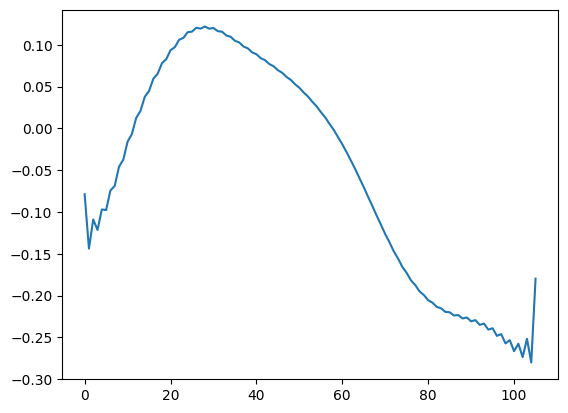

In [9]:
plt.plot(list(train_data.values[2][:-1]))

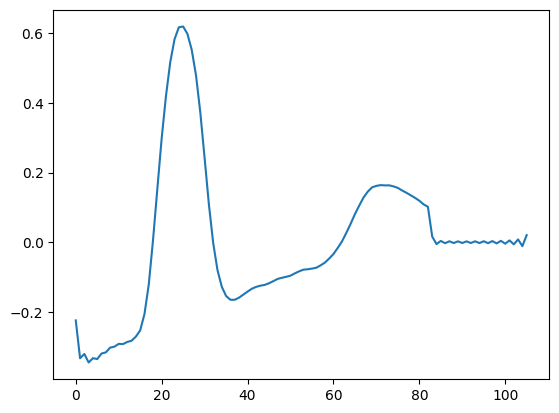

In [10]:
plt.plot(list(test_data.values[2][:-1]))

## Seperate features and labels

Since the objective of this notebook is predict covid from ecg data, the labels are reformatted to binary classes. 1 for COVID(label 4), 0 for non-covid(all others)

In [11]:
X = train_data.iloc[:, :-1]
y = train_data.iloc[:, -1]
y = np.where(y == 4.0, 1, 0)

In [12]:
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]
y_test = np.where(y_test==4, 1, 0)

In [13]:
# Check class distribution
covid_count = np.sum(y == 1)
non_covid_count = np.sum(y == 0)
print(f"Number of COVID examples: {covid_count}")
print(f"Number of Non-COVID examples: {non_covid_count}")
print(f"Percentage of COVID examples: {(covid_count/(len(y)))*100:.1f}%")

Number of COVID examples: 316368
Number of Non-COVID examples: 1265472
Percentage of COVID examples: 20.0%


## Normalize features

In [14]:
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)

## Data Imbalanced
only 20% of the examples are covid classes. we attempt to resolve this in this section

In [15]:
# Use class weights to handle imbalance
class_weights = {0: len(y) / non_covid_count, 1: len(y) / covid_count}

## Split validation set

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)

# Models

## Sample DNN

In [17]:
# sample dnn
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')    
])

In [19]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights, verbose=1)

Epoch 1/10
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 88s 2ms/step - accuracy: 0.6866 - auc: 0.7698 - loss: 1.1171 - precision: 0.3547 - recall: 0.6936 - val_accuracy: 0.7441 - val_auc: 0.8483 - val_loss: 0.4787 - val_precision: 0.4231 - val_recall: 0.7688
Epoch 2/10
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 89s 2ms/step - accuracy: 0.7548 - auc: 0.8552 - loss: 0.9205 - precision: 0.4365 - recall: 0.7652 - val_accuracy: 0.7943 - val_auc: 0.8683 - val_loss: 0.4062 - val_precision: 0.4905 - val_recall: 0.7267
Epoch 3/10
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 90s 2ms/step - accuracy: 0.7719 - auc: 0.8728 - loss: 0.8665 - precision: 0.4588 - recall: 0.7823 - val_accuracy: 0.7861 - val_auc: 0.8733 - val_loss: 0.4075 - val_precision: 0.4782 - val_recall: 0.7590
Epoch 4/10
39546/39546 ━━━━━━━━━━━━━━━━━━━━ 91s 2ms/step - accuracy: 0.7787 - auc: 0.8809 - loss: 0.8415 - precision: 0.4688 - recall: 0.7921 - val_accuracy: 0.7935 - val_auc: 0.8815 - val_loss: 0.4035 - val_precision: 0.4897 - val_recall: 0.7681
Epoch 5/10
3

# Evaluation

In [20]:
results = model.evaluate(X_test, y_test, verbose=0)


In [21]:
loss = results[0]
auc = results[1]
accuracy = results[2]
precision = results[3]
recall = results[4]

In [22]:
print(f"  - Loss: {loss:.4f}")
print(f"  - Precision: {precision:.4f}")
print(f"  - Recall: {recall:.4f}")
print(f"  - Accuracy: {accuracy:.4f}")
print(f"  - AUC: {auc:.4f}")

  - Loss: 0.2690
  - Precision: 0.7278
  - Recall: 0.7428
  - Accuracy: 0.8930
  - AUC: 0.9348


# Utilities

In [4]:
from tensorflow.keras.utils import plot_model

In [8]:
model.build(input_shape=(28, 28, 1))

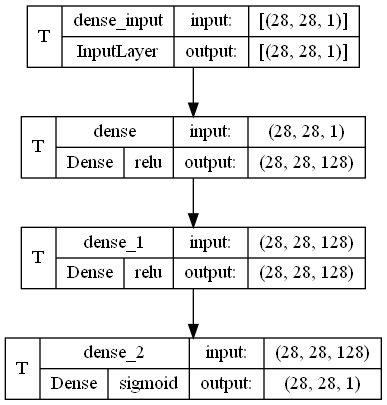

In [14]:
plot_model(model, show_dtype=False, show_layer_activations=True, show_layer_names=True, show_shapes= True, show_trainable=True, expand_nested=True)